In [1]:
# !pip install split-folders
# !pip install scikit-image
# !pip install keras-tuner

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import *
from sklearn.metrics import classification_report, confusion_matrix

# import tensorflow_addons as tfa
# from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.4.0


In [3]:
categories = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [4]:
base_dir = "F:\\Ml files\\Alzymer detection/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [5]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 224
IMAGE_SIZE = [224, 224]
DIM = (IMG_SIZE, IMG_SIZE)

In [6]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


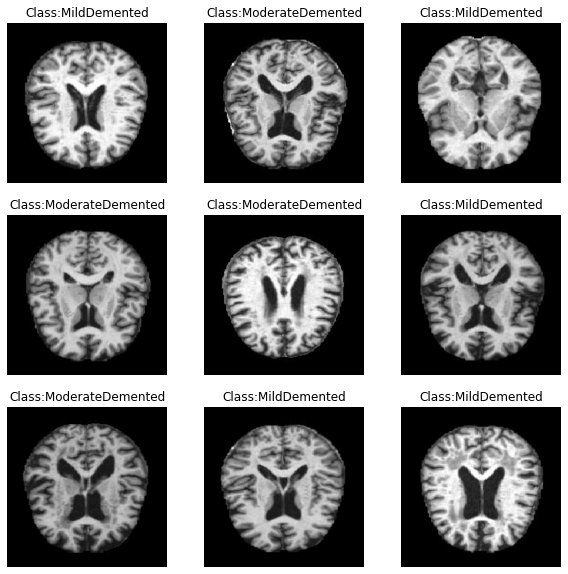

In [7]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [8]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [9]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(6400, 224, 224, 3) (6400, 4)


In [10]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 224, 224, 3) (12800, 4)


In [11]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [12]:
from tensorflow.keras.applications.mobilenet import MobileNet
base_model=MobileNet(weights='imagenet',include_top=False,input_shape = (224, 224, 3))
MobileNetV2_model = Sequential([
        base_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ])


In [13]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)
checkpoint_path = 'F:\\Ml files\\Alzymer detection\\model\\kfold-MobileNetV2-class_11.h5'
saved_model = ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)

In [14]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]

CALLBACKS = [my_callback, rop_callback,saved_model]
    
MobileNetV2_model.compile(optimizer='rmsprop',
                              loss='categorical_crossentropy',
                              metrics=METRICS)

MobileNetV2_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1024)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [15]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 100


history = MobileNetV2_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100
256/256 [==============================] - 49s 148ms/step - loss: 1.4267 - acc: 0.4022 - auc: 0.6719 - val_loss: 3.8983 - val_acc: 0.5068 - val_auc: 0.7002

Epoch 00001: val_loss improved from inf to 3.89832, saving model to F:\Ml files\Alzymer detection\model\kfold-MobileNetV2-class_11.h5
Epoch 2/100
256/256 [==============================] - 38s 147ms/step - loss: 0.6935 - acc: 0.6976 - auc: 0.9149 - val_loss: 1.3861 - val_acc: 0.6675 - val_auc: 0.8667

Epoch 00002: val_loss improved from 3.89832 to 1.38615, saving model to F:\Ml files\Alzymer detection\model\kfold-MobileNetV2-class_11.h5
Epoch 3/100
256/256 [==============================] - 38s 147ms/step - loss: 0.4981 - acc: 0.7908 - auc: 0.9556 - val_loss: 0.8995 - val_acc: 0.7573 - val_auc: 0.9257

Epoch 00003: val_loss improved from 1.38615 to 0.89954, saving model to F:\Ml files\Alzymer detection\model\kfold-MobileNetV2-class_11.h5
Epoch 4/100
256/256 [==============================] - 37s 146ms/step - loss: 0.405

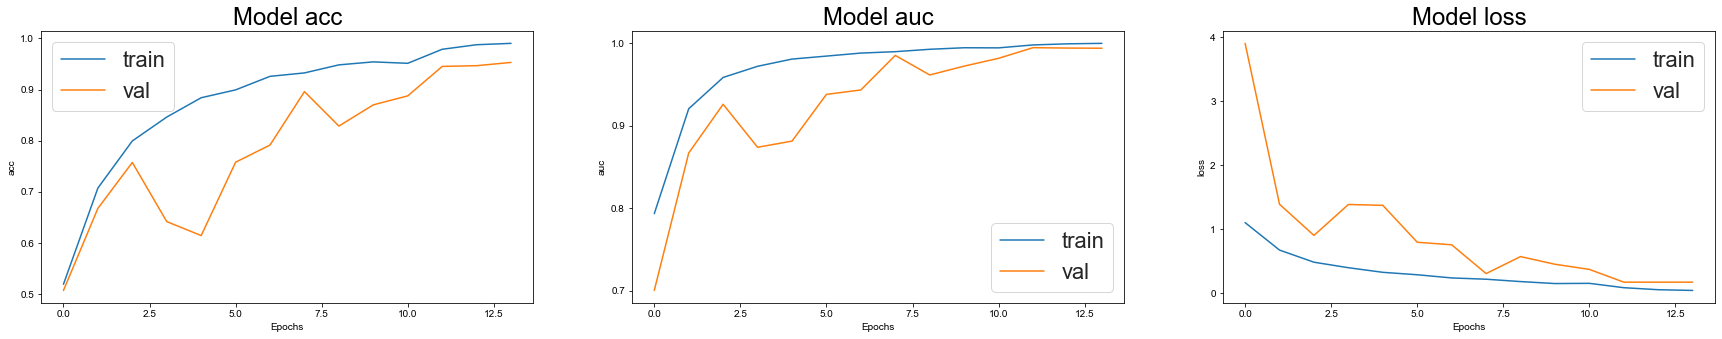

In [16]:
#Plotting the trend of the metrics during training
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    sns.set(font_scale=2)
    sns.set_style('whitegrid')
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [17]:
#Evaluating the model on the data

train_scores = MobileNetV2_model.evaluate(train_data, train_labels)
val_scores = MobileNetV2_model.evaluate(val_data, val_labels)
test_scores = MobileNetV2_model.evaluate(test_data, test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 2s 26ms/step - loss: 0.1612 - acc: 0.9516 - auc: 0.9928
Training Accuracy: 99.98%
Validation Accuracy: 95.31%
Testing Accuracy: 95.16%


In [18]:
#Predicting the test data

pred_labels = MobileNetV2_model.predict(test_data)

#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.99      0.98      0.99       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.94      0.89      0.92       662
ModerateDemented       0.88      0.94      0.91       624

       micro avg       0.95      0.95      0.95      2560
       macro avg       0.95      0.95      0.95      2560
    weighted avg       0.95      0.95      0.95      2560
     samples avg       0.95      0.95      0.95      2560



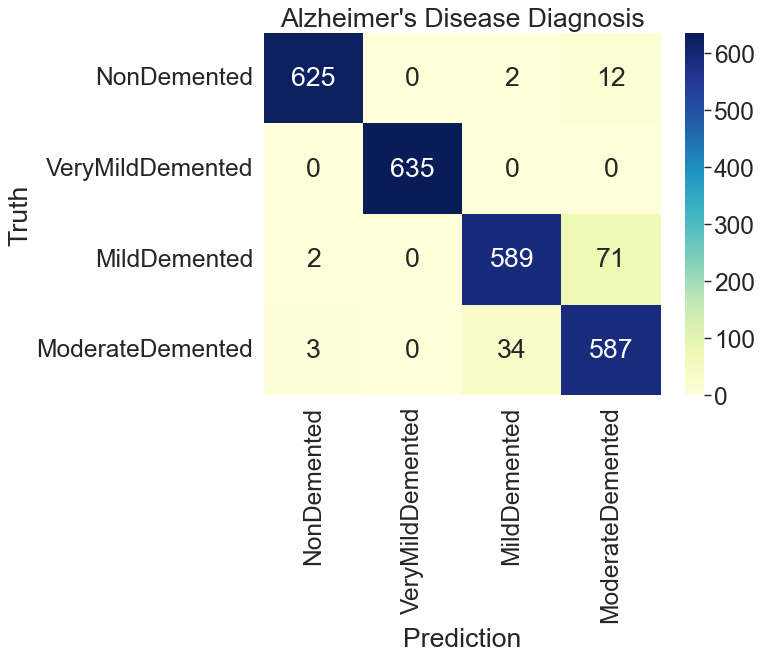

In [19]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='YlGnBu', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

ROC AUC score: 0.9680102432258543


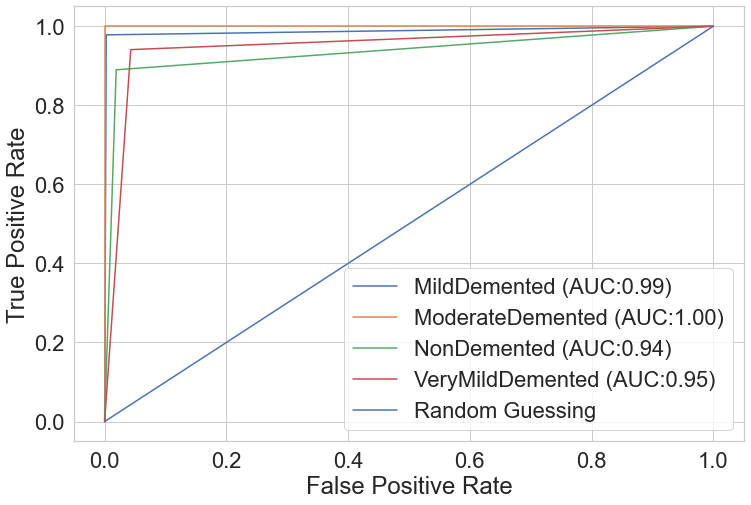

In [20]:
# set plot figure size
from sklearn.preprocessing import LabelBinarizer

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(test_labels)
    y_pred = lb.transform(pred_labels)

    for (idx, c_label) in enumerate(categories):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(test_labels,pred_labels))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()